<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/jihoyeo/mobility-simulation-book/blob/main/ko/chapter2.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>
<br>

## 2.2 스마트카드 데이터 분석

- 대중교통 이용자들의 승하차 정보를 담고 있는 스마트카드 데이터는 도시 교통 패턴을 이해하는 데 핵심적인 자료이다.
- 본 섹션에서는 수도권의 버스 및및 지하철 승하차 데이터를 활용하여 기본적인 분석 및 시각화를 수행한다.
- 본 분석에서 사용하는 데이터는 정류소 위치는 실제 위치지만 이용내역은 실제 데이터에 Noise를 입힌 가상의 데이터이다. 
- 본 섹션에서는 `교통약자`에 집중하여 분석을 수행합니다. 교통약자란 누구일까요? 스마트카드 데이터에서 해당 정보를 추출할 수 있을까? 

#### 연구 질문 (Research Question)
- 교통약자들의 이동 패턴은 일반 사람들과 비교해서 어떻게 다를까? 

In [22]:
import pandas as pd
import os
from datetime import datetime, timedelta
import geopandas as gpd
import numpy as np

In [2]:
# 시각화 라이브러리
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import platform

# 운영체제별 한글 폰트 설정
system = platform.system()
if system == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
    font_name = 'Malgun Gothic'
elif system == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
    font_name = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'DejaVu Sans'
    font_name = 'DejaVu Sans'

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# seaborn 스타일 적용
sns.set(font=font_name, rc={"axes.unicode_minus": False})

# 그래프 크기 기본 설정
plt.rcParams['figure.figsize'] = (10, 6)

### 2.2.1 데이터 읽기

In [3]:
def load_trip_data(date):
    """
    특정 날짜의 TCD 데이터를 불러오는 함수
    
    Args:
        date (str): 날짜 문자열 (예: '20240923')
    
    Returns:
        pd.DataFrame: 데이터프레임
    """
    file_path = f'../data/smartcard/TCD_{date}_modify.parquet'
    df = pd.read_parquet(file_path)
    return df

# 날짜 설정 및 데이터 로드
date = '20240923'
df = load_trip_data(date)


In [4]:
print("=" * 50)
print("📊 스마트카드 승하차 이력 데이터 (TCD) 정보")
print("=" * 50)
print(f"- 데이터 크기: {df.shape[0]:,}건의 승하차 이력")
print(f"- 컬럼 수: {df.shape[1]}개")
print("- 설명: 대중교통(버스, 지하철) 이용자들의 승차/하차 정보를 담고 있는 교통카드 이용 내역")
print("- 포함 정보: 승하차 시간, 정류장/역 정보, 요금, 이동거리, 환승정보, 이용자 구분 등")
print("- 주요 컬럼:")
print("  * 교통카드 사용자 구분 코드: 1(일반), 2(어린이), 3(청소년), 4(경로), 5(장애인)")
print("  * 환승 건수: 해당 통행에서의 환승 횟수")
print("  * 총 통행 거리: 미터 단위")
print("  * 총 소요 시간: 초 단위")
print("=" * 50)


📊 스마트카드 승하차 이력 데이터 (TCD) 정보
- 데이터 크기: 770,455건의 승하차 이력
- 컬럼 수: 123개
- 설명: 대중교통(버스, 지하철) 이용자들의 승차/하차 정보를 담고 있는 교통카드 이용 내역
- 포함 정보: 승하차 시간, 정류장/역 정보, 요금, 이동거리, 환승정보, 이용자 구분 등
- 주요 컬럼:
  * 교통카드 사용자 구분 코드: 1(일반), 2(어린이), 3(청소년), 4(경로), 5(장애인)
  * 환승 건수: 해당 통행에서의 환승 횟수
  * 총 통행 거리: 미터 단위
  * 총 소요 시간: 초 단위


#### 정류소 정보 불러오기

In [176]:
# STTN 파일 불러오기 (20240923 데이터만)
def load_sttn_data(date):
    """
    특정 날짜의 STTN 데이터를 불러오는 함수
    
    Args:
        date (str): 날짜 문자열 (예: '20240923')
    
    Returns:
        pd.DataFrame: 정류장 데이터프레임
    """
    file_path = f'../data/smartcard/STTN_{date}.parquet'
    sttn_df = pd.read_parquet(file_path)
    return sttn_df

# STTN 데이터 로드
sttn_df = load_sttn_data(date)

# 정류장 ID가 중복인 행 모두 제거
sttn_unique = sttn_df.drop_duplicates(subset=['정류장 ID'], keep=False)

sttn_unique


,운행일자,정산사 ID,정산 지역 코드,정류장 ID,정류장 명칭,정류장 ARS번호,정류장 X 좌표,정류장 Y 좌표,시도코드,시도명,시군구코드,시군구명,읍면동코드,읍면동명
0,20240923,3,EE10131000,3100001,동울산우체국,~,35.51093,129.4297,31,울산광역시,31170,동구,3117010400,전하동
1,20240923,3,EE10131000,3100002,청량초등학교,~,35.48747,129.2983,31,울산광역시,31710,울주군,3171026221,청량읍
2,20240923,3,EE10131000,3100003,청량초등학교,~,35.48757,129.29838,31,울산광역시,31710,울주군,3171026221,청량읍
3,20240923,3,EE10131000,3100004,화봉쌍용예가,~,35.5938,129.3676,31,울산광역시,31200,북구,3120012500,화봉동
4,20240923,3,EE10131000,3100005,화봉휴먼시아2단지,~,35.59398,129.3677,31,울산광역시,31200,북구,3120012500,화봉동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129824,20240923,20,2600000000,8019,남창,~,35.418539,129.28289,31,울산광역시,31710,울주군,3171025624,온양읍
129825,20240923,20,2600000000,8020,망양,~,35.456522,129.287872,31,울산광역시,31710,울주군,3171025623,온양읍
129826,20240923,20,2600000000,8021,덕하,~,35.493964,129.303064,31,울산광역시,31710,울주군,3171026224,청량읍
129827,20240923,20,2600000000,8022,개운포,~,35.507907,129.321188,31,울산광역시,31140,남구,3114011000,상개동


In [6]:
print("=" * 50)
print("🚏 정류장 정보 데이터 (STTN) 정보")
print("=" * 50)
print(f"- 데이터 크기: {sttn_unique.shape[0]:,}개의 고유 정류장")
print(f"- 컬럼 수: {sttn_unique.shape[1]}개")
print("- 설명: 대중교통 정류장 및 지하철역의 위치 정보와 행정구역 정보를 담고 있는 데이터")
print("- 포함 정보: 정류장 ID, 명칭, 좌표, 행정구역코드, 행정구역명 등")
print("- 주요 컬럼:")
print("  * 정류장 ID: 각 정류장의 고유 식별번호")
print("  * 정류장 X/Y 좌표: 위경도 좌표 (WGS84)")
print("  * 시도/시군구/읍면동: 행정구역 코드 및 명칭")
print("- 활용: TCD 데이터의 승하차 정류장 정보와 매핑하여 공간분석 수행")
print("=" * 50)


🚏 정류장 정보 데이터 (STTN) 정보
- 데이터 크기: 128,545개의 고유 정류장
- 컬럼 수: 10개
- 설명: 대중교통 정류장 및 지하철역의 위치 정보와 행정구역 정보를 담고 있는 데이터
- 포함 정보: 정류장 ID, 명칭, 좌표, 행정구역코드, 행정구역명 등
- 주요 컬럼:
  * 정류장 ID: 각 정류장의 고유 식별번호
  * 정류장 X/Y 좌표: 위경도 좌표 (WGS84)
  * 시도/시군구/읍면동: 행정구역 코드 및 명칭
- 활용: TCD 데이터의 승하차 정류장 정보와 매핑하여 공간분석 수행


### 2.2.2 O-D 데이터 만들기

- 현재의 데이터는 O-D 데이터라고는 할 수 없습니다. 개인의 통행이 여러번에 걸쳐서 발생하기 때문에 개별 Trip 마다 컬럼의 수가 달라지는 문제가 있습니다.  
- 이 문제를 어떻게 해결할 수 있을까요? 
- 완결성 있는 정류소 단위의 출발지-목적지 데이터를 만들어 봅시다.
- 출발지 정류소 ID | 교통카드 사용자 구분 코드 | 출발시간 | 도착시간 | 도착지 정류소 ID | 환승횟수 | 총 통행 거리	| 총 탑승 시간	| 총 소요 시간 컬럼을 포함해서 만들어보세요

In [7]:
from datetime import timedelta

# '시작'과 '종료'로 시작하는 컬럼 추출
start_end_cols = [col for col in df.columns if col.startswith(('시작', '종료'))]

# 기본 컬럼 리스트
base_cols = [
    "교통카드 사용자 구분 코드",
    "환승 건수",
    "총 통행 거리",
    "총 탑승 시간", 
    "총 소요 시간"
]

# 모든 컬럼 합치기
all_cols = start_end_cols + base_cols

# 원하는 컬럼만 정제
df_refined = df[all_cols].rename(columns={
    "시작 승차 역 ID": "출발지 정류소 ID",
    "종료 하차 역 ID": "도착지 정류소 ID",
    "환승 건수": "환승횟수"
})

print(df_refined.head())

           시작 승차 일시 시작 교통수단 코드 시작 교통수단 구분 코드 시작 승차 노선 ID 출발지 정류소 ID 시작 승차 금액  \
0  20240923221246.0        202             T         106       1853        0   
1  20240923124248.0        203             T         208       2826        0   
2  20240923081625.0        203             T         208       2823        0   
3  20240923163554.0        202             T         106       1855        0   
4  20240923160512.0        203             T         208       2826        0   

           종료 하차 일시 종료 교통수단 코드 종료 교통수단 구분 코드 종료 하차 노선 ID 도착지 정류소 ID  \
0  20240923222933.0        202             T         106       1857   
1  20240923125036.0        203             T         208       2827   
2  20240923082515.0        203             T         208       2827   
3  20240923164257.0        202             T         106       1856   
4  20240923162457.0        203             T         208       2821   

  교통카드 사용자 구분 코드 환승횟수 총 통행 거리 총 탑승 시간 총 소요 시간  
0              1    0    8100    1007  1007.

In [8]:
# 문자열에서 뒤의 ".0" 제거
df_refined["출발시간"] = (
    df_refined["시작 승차 일시"]
    .astype(str)                      # 문자열로 변환
    .str.replace(r"\.0$", "", regex=True)  # 뒤의 ".0" 제거
    .pipe(pd.to_datetime, format="%Y%m%d%H%M%S", errors="coerce")  # datetime 변환
)

df_refined["도착시간"] = (
    df_refined["종료 하차 일시"]
    .astype(str)
    .str.replace(r"\.0$", "", regex=True)
    .pipe(pd.to_datetime, format="%Y%m%d%H%M%S", errors="coerce")
)

print(df_refined[["시작 승차 일시", "출발시간", "종료 하차 일시", "도착시간"]].head())

           시작 승차 일시                출발시간          종료 하차 일시                도착시간
0  20240923221246.0 2024-09-23 22:12:46  20240923222933.0 2024-09-23 22:29:33
1  20240923124248.0 2024-09-23 12:42:48  20240923125036.0 2024-09-23 12:50:36
2  20240923081625.0 2024-09-23 08:16:25  20240923082515.0 2024-09-23 08:25:15
3  20240923163554.0 2024-09-23 16:35:54  20240923164257.0 2024-09-23 16:42:57
4  20240923160512.0 2024-09-23 16:05:12  20240923162457.0 2024-09-23 16:24:57


In [9]:
# 컬럼명 통일을 위한 매핑 딕셔너리
column_mapping = {
    "시작 승차 일시": "출발 승차 일시",
    "시작 교통수단 코드": "출발 교통수단 코드", 
    "시작 교통수단 구분 코드": "출발 교통수단 구분 코드",
    "시작 승차 노선 ID": "출발 승차 노선 ID",
    "시작 승차 금액": "출발 승차 금액",
    "종료 하차 일시": "도착 하차 일시",
    "종료 교통수단 코드": "도착 교통수단 코드",
    "종료 교통수단 구분 코드": "도착 교통수단 구분 코드", 
    "종료 하차 노선 ID": "도착 하차 노선 ID"
}

# 컬럼명 변경
df_refined = df_refined.rename(columns=column_mapping)

# 변경된 컬럼명 확인
df_refined.columns

Index(['출발 승차 일시', '출발 교통수단 코드', '출발 교통수단 구분 코드', '출발 승차 노선 ID', '출발지 정류소 ID',
       '출발 승차 금액', '도착 하차 일시', '도착 교통수단 코드', '도착 교통수단 구분 코드', '도착 하차 노선 ID',
       '도착지 정류소 ID', '교통카드 사용자 구분 코드', '환승횟수', '총 통행 거리', '총 탑승 시간', '총 소요 시간',
       '출발시간', '도착시간'],
      dtype='object')

### 2.2.3 기초 통계 분석
- 시간대별 승하차 패턴을 분석해봅시다. 언제 가장 이용량이 많을까요? 
- 비교통약자, 어린이, 경로, 장애인별로 평균탑승시간 및 평균이동거리, 환승횟수수를 시각화 해보고 해석해 봅시다.

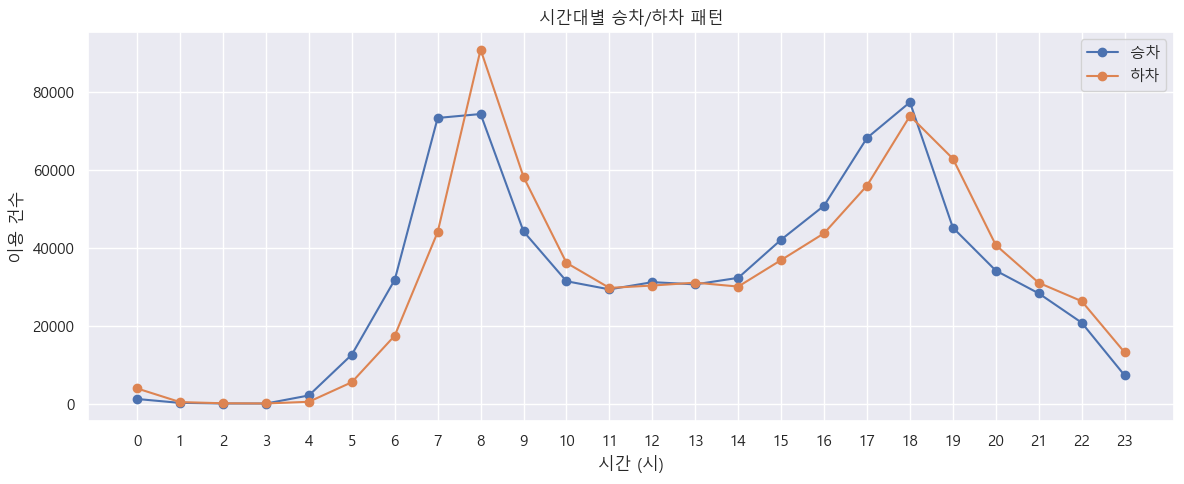

[시간대별 패턴 요약]
- 승차 피크: 18시 (77,480건)
- 하차 피크: 8시 (91,022건)


In [10]:
# 2.2.3 기초 통계 분석
# 1) 시간대별 승하차 패턴 (출발시간=승차, 도착시간=하차)
board_df = df_refined[["출발시간"]].dropna().copy()
board_df["hour"] = board_df["출발시간"].dt.hour

alight_df = df_refined[["도착시간"]].dropna().copy()
alight_df["hour"] = alight_df["도착시간"].dt.hour

board_counts = board_df["hour"].value_counts().sort_index()
alight_counts = alight_df["hour"].value_counts().sort_index()

# 모든 시간대(0~23시) 포함하도록 재색인
hours = pd.RangeIndex(0, 24)
board_counts = board_counts.reindex(hours, fill_value=0)
alight_counts = alight_counts.reindex(hours, fill_value=0)

# 시각화
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(board_counts.index, board_counts.values, marker="o", label="승차")
ax.plot(alight_counts.index, alight_counts.values, marker="o", label="하차")
ax.set_xticks(range(0, 24))
ax.set_xlabel("시간 (시)")
ax.set_ylabel("이용 건수")
ax.set_title("시간대별 승차/하차 패턴")
ax.legend()
plt.tight_layout()
plt.show()

# 요약 출력
peak_board_hour = int(board_counts.idxmax())
peak_alight_hour = int(alight_counts.idxmax())
print("[시간대별 패턴 요약]")
print(f"- 승차 피크: {peak_board_hour}시 ({board_counts.max():,}건)")
print(f"- 하차 피크: {peak_alight_hour}시 ({alight_counts.max():,}건)")

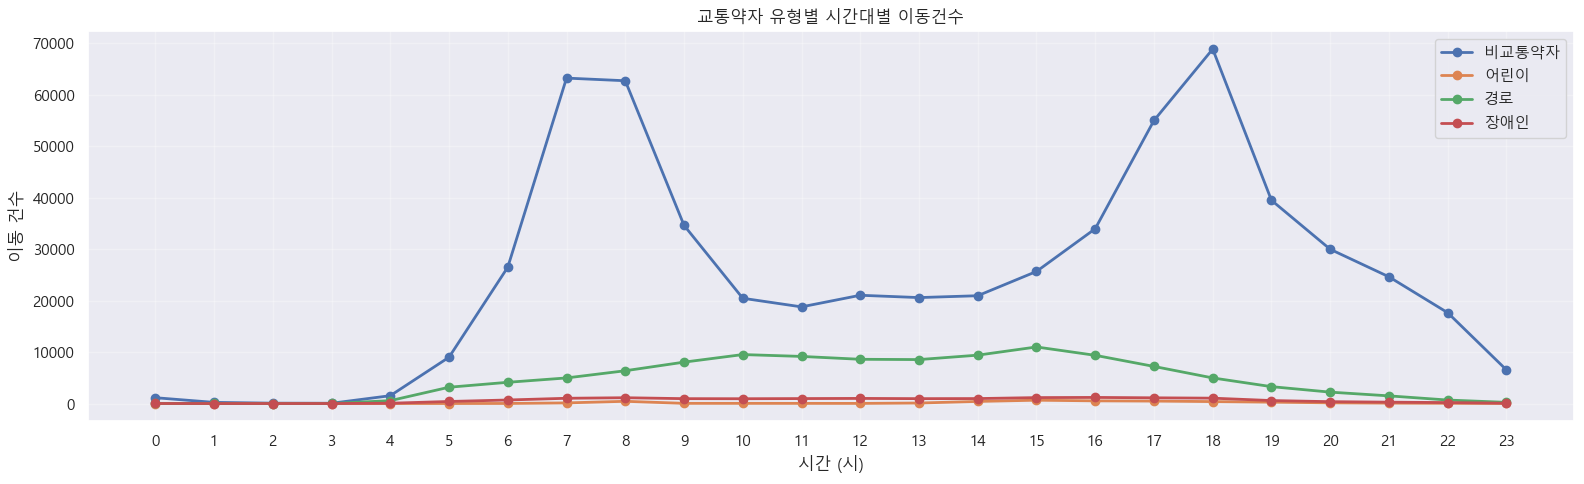

[교통약자 유형별 피크 시간 요약]


In [11]:
# 3) 교통약자 유형별 시간대별 이동건수 시각화

# 교통카드 사용자 구분 코드 매핑 정의
user_group_map = {1: "비교통약자", 2: "어린이", 3: "청소년", 4: "경로", 5: "장애인"}

# 분석을 위한 데이터프레임 복사본 생성
df_hourly = df_refined.copy()

# 교통카드 사용자 구분 코드를 숫자형으로 변환
df_hourly["교통카드 사용자 구분 코드"] = pd.to_numeric(df_hourly["교통카드 사용자 구분 코드"], errors='coerce')

# 사용자 구분 코드를 이용자유형 텍스트로 매핑
df_hourly["이용자유형"] = df_hourly["교통카드 사용자 구분 코드"].map(user_group_map)

# 분석 대상 그룹 정의
target_groups = ["비교통약자", "어린이", "경로", "장애인"]
df_hourly = df_hourly[df_hourly["이용자유형"].isin(target_groups)].copy()

# 출발시간에서 시간 추출
df_hourly = df_hourly[["출발시간", "이용자유형"]].dropna().copy()
df_hourly["hour"] = df_hourly["출발시간"].dt.hour

# 유형별, 시간대별 이동건수 계산
hourly_counts = df_hourly.groupby(["이용자유형", "hour"]).size().unstack(fill_value=0)

# 모든 시간대(0~23시) 포함하도록 재색인
hours = pd.RangeIndex(0, 24)
hourly_counts = hourly_counts.reindex(columns=hours, fill_value=0)

# 시각화
fig, ax = plt.subplots(figsize=(16, 5))
for user_type in target_groups:
    if user_type in hourly_counts.index:
        ax.plot(hourly_counts.columns, hourly_counts.loc[user_type], 
                marker="o", label=user_type, linewidth=2)

ax.set_xticks(range(0, 24))
ax.set_xlabel("시간 (시)")
ax.set_ylabel("이동 건수")
ax.set_title("교통약자 유형별 시간대별 이동건수")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 유형별 피크 시간 분석
print("[교통약자 유형별 피크 시간 요약]")
for user_type in target_groups:
    if user_type in hourly_counts.index:
        peak_hour = hourly_counts.loc[user_type].idxmax()
        peak_count = hourly_counts.loc[user_type].max()
#        print(f"- {user_type}: {peak_hour}시 ({peak_count:,}건)")

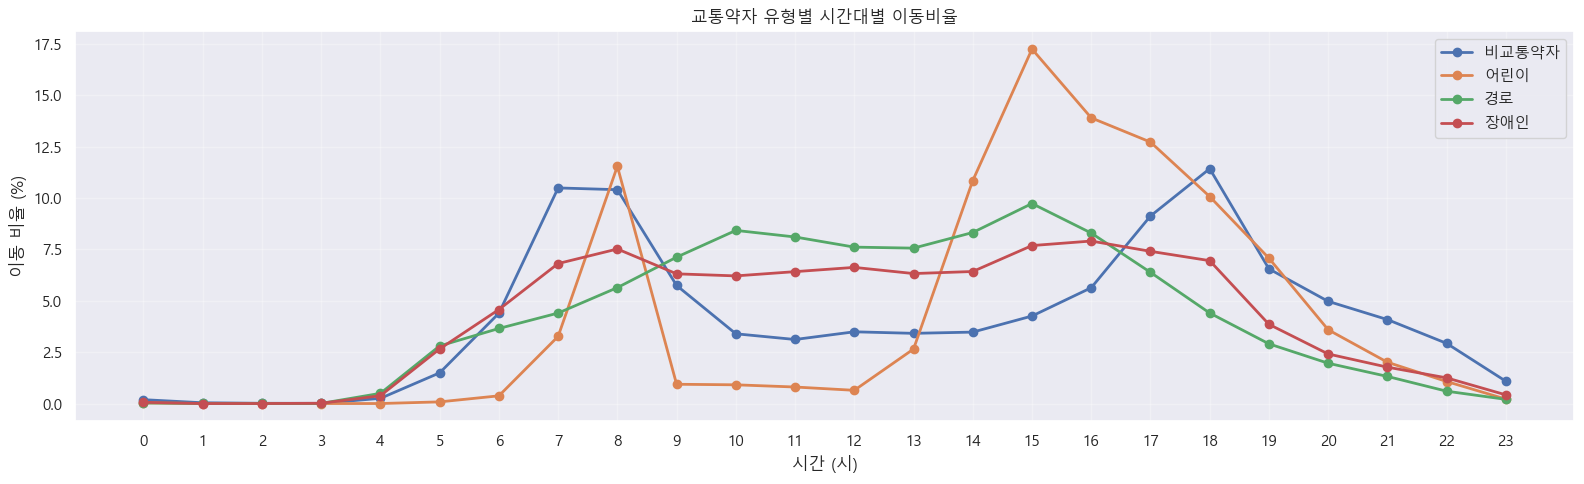

[교통약자 유형별 피크 시간 요약]
- 비교통약자: 18시 (11.4%)
- 어린이: 15시 (17.3%)
- 경로: 15시 (9.7%)
- 장애인: 16시 (7.9%)


In [12]:
# 3) 교통약자 유형별 시간대별 이동건수 비율 시각화
# 1) 내가 가진 데이터에 대한 설명: 
# 2) 내가 만들고 싶은 그림: 


# 교통카드 사용자 구분 코드 매핑 정의
user_group_map = {1: "비교통약자", 2: "어린이", 3: "청소년", 4: "경로", 5: "장애인"}

# 분석을 위한 데이터프레임 복사본 생성
df_hourly = df_refined.copy()

# 교통카드 사용자 구분 코드를 숫자형으로 변환
df_hourly["교통카드 사용자 구분 코드"] = pd.to_numeric(df_hourly["교통카드 사용자 구분 코드"], errors='coerce')

# 사용자 구분 코드를 이용자유형 텍스트로 매핑
df_hourly["이용자유형"] = df_hourly["교통카드 사용자 구분 코드"].map(user_group_map)

# 분석 대상 그룹 정의
target_groups = ["비교통약자", "어린이", "경로", "장애인"]
df_hourly = df_hourly[df_hourly["이용자유형"].isin(target_groups)].copy()

# 출발시간에서 시간 추출
df_hourly = df_hourly[["출발시간", "이용자유형"]].dropna().copy()
df_hourly["hour"] = df_hourly["출발시간"].dt.hour

# 유형별, 시간대별 이동건수 계산
hourly_counts = df_hourly.groupby(["이용자유형", "hour"]).size().unstack(fill_value=0)

# 모든 시간대(0~23시) 포함하도록 재색인
hours = pd.RangeIndex(0, 24)
hourly_counts = hourly_counts.reindex(columns=hours, fill_value=0)

# 각 유형별 전체 이동건수로 나누어 비율로 변환 (행별로 정규화)
hourly_ratios = hourly_counts.div(hourly_counts.sum(axis=1), axis=0) * 100

# 시각화
fig, ax = plt.subplots(figsize=(16, 5))
for user_type in target_groups:
    if user_type in hourly_ratios.index:
        ax.plot(hourly_ratios.columns, hourly_ratios.loc[user_type], 
                marker="o", label=user_type, linewidth=2)

ax.set_xticks(range(0, 24))
ax.set_xlabel("시간 (시)")
ax.set_ylabel("이동 비율 (%)")
ax.set_title("교통약자 유형별 시간대별 이동비율")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 유형별 피크 시간 분석
print("[교통약자 유형별 피크 시간 요약]")
for user_type in target_groups:
    if user_type in hourly_ratios.index:
        peak_hour = hourly_ratios.loc[user_type].idxmax()
        peak_ratio = hourly_ratios.loc[user_type].max()
        print(f"- {user_type}: {peak_hour}시 ({peak_ratio:.1f}%)")

In [13]:
# 2) 이용자 유형별 평균탑승시간/이동거리/환승횟수 시각화

# 교통카드 사용자 구분 코드 매핑 정의
# 1: 일반(비교통약자), 2: 어린이, 3: 청소년, 4: 경로(노인), 5: 장애인
user_group_map = {1: "비교통약자", 2: "어린이", 3: "청소년", 4: "경로", 5: "장애인"}

# 분석을 위한 데이터프레임 복사본 생성
df_stats = df_refined.copy()

# 교통카드 사용자 구분 코드를 숫자형으로 변환
# 텍스트로 저장된 경우가 있어서 pd.to_numeric으로 변환
# errors='coerce'는 변환 불가능한 값을 NaN으로 처리
df_stats["교통카드 사용자 구분 코드"] = pd.to_numeric(df_stats["교통카드 사용자 구분 코드"], errors='coerce')

# 사용자 구분 코드를 이용자유형 텍스트로 매핑
df_stats["이용자유형"] = df_stats["교통카드 사용자 구분 코드"].map(user_group_map)

# 분석 대상 그룹 정의 (청소년 제외, 문제에서 요구한 4개 그룹만)
target_groups = ["비교통약자", "어린이", "경로", "장애인"]
# 해당 그룹의 데이터만 필터링
df_stats = df_stats[df_stats["이용자유형"].isin(target_groups)].copy()

# 분석에 필요한 컬럼들을 숫자형으로 변환
# 원본 데이터가 문자열이나 객체형으로 저장되어 있을 수 있음
df_stats["총 탑승 시간"] = pd.to_numeric(df_stats["총 탑승 시간"], errors='coerce')  # 초 단위
df_stats["총 통행 거리"] = pd.to_numeric(df_stats["총 통행 거리"], errors='coerce')  # 미터 단위
df_stats["환승횟수"] = pd.to_numeric(df_stats["환승횟수"], errors='coerce')

# 분석에 필요한 핵심 컬럼에 결측치가 있는 행 제거
# 세 컬럼 중 하나라도 결측치가 있으면 해당 행 제거
df_stats = df_stats.dropna(subset=["총 탑승 시간", "총 통행 거리", "환승횟수"])

# 단위 변환 (가독성과 해석 편의를 위해)
# 총 탑승 시간: 초 → 분으로 변환 (60으로 나누기)
df_stats["평균탑승시간_분"] = df_stats["총 탑승 시간"] / 60
# 총 통행 거리: 미터 → 킬로미터로 변환 (1000으로 나누기)
df_stats["이동거리_km"] = df_stats["총 통행 거리"] / 1000

# 이용자 유형별로 그룹화하여 평균값 계산
grouped = (
    df_stats.groupby("이용자유형")[
        ["평균탑승시간_분", "이동거리_km", "환승횟수"]  # 분석할 세 가지 지표
    ]
    .mean()  # 그룹별 평균 계산
    .round(2)  # 소수점 둘째 자리까지 반올림
    .reindex(target_groups)  # 지정된 순서로 행 정렬 (비교통약자, 어린이, 경로, 장애인)
)

grouped

,평균탑승시간_분,이동거리_km,환승횟수
이용자유형,,,
비교통약자,33.62,14.10,0.30
어린이,13.36,4.26,0.11
경로,28.64,11.16,0.07
장애인,31.75,12.43,0.06


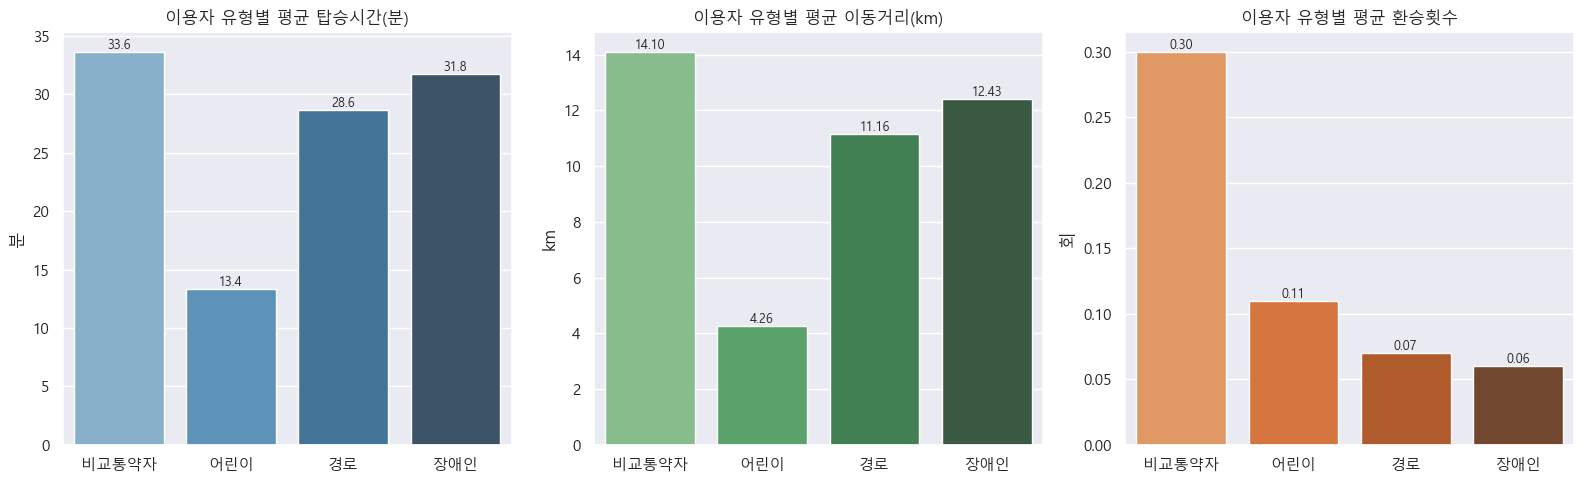

[이용자 유형별 평균 지표 요약]
- 평균 탑승시간(분):
이용자유형
비교통약자    33.62
장애인      31.75
경로       28.64
어린이      13.36
Name: 평균탑승시간_분, dtype: float64
- 평균 이동거리(km):
이용자유형
비교통약자    14.10
장애인      12.43
경로       11.16
어린이       4.26
Name: 이동거리_km, dtype: float64
- 평균 환승횟수:
이용자유형
비교통약자    0.30
어린이      0.11
경로       0.07
장애인      0.06
Name: 환승횟수, dtype: float64


In [14]:
# 시각화를 위한 matplotlib와 seaborn 설정
fig, axes = plt.subplots(1, 3, figsize=(16, 5))  # 1행 3열의 서브플롯 생성

# 1) 첫 번째 차트: 평균 탑승시간 바차트
# sns.barplot(): seaborn의 막대차트 함수
# - x: x축 데이터 (이용자 유형)
# - y: y축 데이터 (평균 탑승시간)
# - ax: 그래프를 그릴 축 지정
# - hue: 막대 색상을 다르게 하기 위한 구분 변수
# - palette: 색상 팔레트 지정 ("Blues_d"는 파란색 계열의 어두운 색상)
# - legend=False: 범례 숨기기
sns.barplot(x=grouped.index, y=grouped["평균탑승시간_분"], ax=axes[0], hue=grouped.index, palette="Blues_d", legend=False)
axes[0].set_title("이용자 유형별 평균 탑승시간(분)")  # 차트 제목 설정
axes[0].set_xlabel("")  # x축 라벨 제거 (이용자 유형이 이미 표시되므로)
axes[0].set_ylabel("분")  # y축 라벨 설정

# 막대 위에 수치 표시하기
# axes[0].containers: 막대차트의 각 막대를 담고 있는 컨테이너 객체
# bar_label(): 막대 위에 라벨(수치) 추가하는 함수
# fmt="%.1f": 소수점 첫째 자리까지 표시하는 형식
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.1f", fontsize=9)

# 2) 두 번째 차트: 평균 이동거리 바차트
# "Greens_d": 녹색 계열의 어두운 색상 팔레트 사용
sns.barplot(x=grouped.index, y=grouped["이동거리_km"], ax=axes[1], hue=grouped.index, palette="Greens_d", legend=False)
axes[1].set_title("이용자 유형별 평균 이동거리(km)")
axes[1].set_xlabel("")
axes[1].set_ylabel("km")

# 거리는 소수점 둘째 자리까지 표시 (fmt="%.2f")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", fontsize=9)

# 3) 세 번째 차트: 평균 환승횟수 바차트
# "Oranges_d": 주황색 계열의 어두운 색상 팔레트 사용
sns.barplot(x=grouped.index, y=grouped["환승횟수"], ax=axes[2], hue=grouped.index, palette="Oranges_d", legend=False)
axes[2].set_title("이용자 유형별 평균 환승횟수")
axes[2].set_xlabel("")
axes[2].set_ylabel("회")

# 환승횟수도 소수점 둘째 자리까지 표시
for container in axes[2].containers:
    axes[2].bar_label(container, fmt="%.2f", fontsize=9)

# plt.tight_layout(): 서브플롯 간의 간격을 자동으로 조정하여 겹치지 않게 배치
plt.tight_layout()
# 차트 출력
plt.show()

# 분석 결과 해석을 위한 요약 정보 출력
print("[이용자 유형별 평균 지표 요약]")

# sort_values(ascending=False): 내림차순 정렬 (높은 값부터 표시)
print("- 평균 탑승시간(분):")
print(grouped["평균탑승시간_분"].sort_values(ascending=False))

print("- 평균 이동거리(km):")
print(grouped["이동거리_km"].sort_values(ascending=False))

print("- 평균 환승횟수:")
print(grouped["환승횟수"].sort_values(ascending=False))


### 2.2.4 공간 분석

- 스마트카드 데이터에는 위치 정보 (위도 및 경도)가 존재하지 않습니다. 
- 어떻게 하면 스마트카드 데이터를 공간상에 시각화 할 수 있을까요? 아래 작업을 수행해 봅시다.
    - 승차량이 많은 지역을 H3 cell 단위로 공간상에 나타내봅시다
    - 하차량이 많은 지역을 H3 cell 단위로 공간상에 나타내봅시다
    - H3 cell은 레벨에 따라서 크기가 다릅니다. Level을 입력했을 때 해당 레벨에 맞는 시각화가 가능하도록 만들어봅시다
- 성남시 수정구만을 대상으로 해봅시다
    - 교통약자 유형별로 사람들이 많이 대중교통을 타고 내리는 지역을 시각화 할 수 있나요?


In [145]:
df_refined

,출발 승차 일시,출발 교통수단 코드,출발 교통수단 구분 코드,출발 승차 노선 ID,출발지 정류소 ID,출발 승차 금액,도착 하차 일시,도착 교통수단 코드,도착 교통수단 구분 코드,도착 하차 노선 ID,도착지 정류소 ID,교통카드 사용자 구분 코드,환승횟수,총 통행 거리,총 탑승 시간,총 소요 시간,출발시간,도착시간
0,20240923221246.0,202,T,106,1853,0,20240923222933.0,202,T,106,1857,1,0,8100,1007,1007.0,2024-09-23 22:12:46,2024-09-23 22:29:33
1,20240923124248.0,203,T,208,2826,0,20240923125036.0,203,T,208,2827,4,0,1000,468,468.0,2024-09-23 12:42:48,2024-09-23 12:50:36
2,20240923081625.0,203,T,208,2823,0,20240923082515.0,203,T,208,2827,4,0,3500,530,530.0,2024-09-23 08:16:25,2024-09-23 08:25:15
3,20240923163554.0,202,T,106,1855,0,20240923164257.0,202,T,106,1856,2,0,1100,423,423.0,2024-09-23 16:35:54,2024-09-23 16:42:57
4,20240923160512.0,203,T,208,2826,0,20240923162457.0,203,T,208,2821,1,0,5300,1185,1185.0,2024-09-23 16:05:12,2024-09-23 16:24:57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
770450,20240923151149.0,533,B,41002019,4160070,2800,20240923160141.0,582,B,41382002,4118191,1,2,24657,1826,2992.0,2024-09-23 15:11:49,2024-09-23 16:01:41
770451,20240923134139.0,582,B,41213002,4100527,1350,20240923135016.0,582,B,41213002,4100415,1,0,3221,517,517.0,2024-09-23 13:41:39,2024-09-23 13:50:16
770452,20240923082721.0,202,T,106,1851,1400,20240923084049.0,202,T,106,1854,1,0,4200,808,808.0,2024-09-23 08:27:21,2024-09-23 08:40:49
770453,20240923155132.0,202,T,106,1854,1400,20240923160420.0,202,T,106,1852,1,0,3200,768,768.0,2024-09-23 15:51:32,2024-09-23 16:04:20


In [147]:
print("sttn_unique 데이터프레임의 데이터 타입:")
print(sttn_unique.dtypes)
print("\n")
print("sttn_unique 데이터프레임 정보:")
print(sttn_unique.info())

sttn_unique 데이터프레임의 데이터 타입:
운행일자         object
정산사 ID       object
정산 지역 코드     object
정류장 ID       object
정류장 명칭       object
정류장 ARS번호    object
정류장 X 좌표     object
정류장 Y 좌표     object
시도코드         object
시도명          object
시군구코드        object
시군구명         object
읍면동코드        object
읍면동명         object
dtype: object


sttn_unique 데이터프레임 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 113672 entries, 0 to 129828
Data columns (total 14 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   운행일자       113672 non-null  object
 1   정산사 ID     113672 non-null  object
 2   정산 지역 코드   113672 non-null  object
 3   정류장 ID     113672 non-null  object
 4   정류장 명칭     113672 non-null  object
 5   정류장 ARS번호  113672 non-null  object
 6   정류장 X 좌표   113672 non-null  object
 7   정류장 Y 좌표   113672 non-null  object
 8   시도코드       113672 non-null  object
 9   시도명        113672 non-null  object
 10  시군구코드      113672 non-null  object
 11  시군구명       113672 non-

In [178]:
sttn_unique = sttn_unique.rename(columns={
    '정류장 X 좌표': '정류장 Y 좌표',
    '정류장 Y 좌표': '정류장 X 좌표'
})
# 그 다음 숫자 변환
sttn_unique[['정류장 X 좌표','정류장 Y 좌표']] = sttn_unique[['정류장 X 좌표','정류장 Y 좌표']].apply(
    pd.to_numeric, errors='coerce'
)

In [179]:
sttn_unique

,운행일자,정산사 ID,정산 지역 코드,정류장 ID,정류장 명칭,정류장 ARS번호,정류장 Y 좌표,정류장 X 좌표,시도코드,시도명,시군구코드,시군구명,읍면동코드,읍면동명
0,20240923,3,EE10131000,3100001,동울산우체국,~,35.510930,129.429700,31,울산광역시,31170,동구,3117010400,전하동
1,20240923,3,EE10131000,3100002,청량초등학교,~,35.487470,129.298300,31,울산광역시,31710,울주군,3171026221,청량읍
2,20240923,3,EE10131000,3100003,청량초등학교,~,35.487570,129.298380,31,울산광역시,31710,울주군,3171026221,청량읍
3,20240923,3,EE10131000,3100004,화봉쌍용예가,~,35.593800,129.367600,31,울산광역시,31200,북구,3120012500,화봉동
4,20240923,3,EE10131000,3100005,화봉휴먼시아2단지,~,35.593980,129.367700,31,울산광역시,31200,북구,3120012500,화봉동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129824,20240923,20,2600000000,8019,남창,~,35.418539,129.282890,31,울산광역시,31710,울주군,3171025624,온양읍
129825,20240923,20,2600000000,8020,망양,~,35.456522,129.287872,31,울산광역시,31710,울주군,3171025623,온양읍
129826,20240923,20,2600000000,8021,덕하,~,35.493964,129.303064,31,울산광역시,31710,울주군,3171026224,청량읍
129827,20240923,20,2600000000,8022,개운포,~,35.507907,129.321188,31,울산광역시,31140,남구,3114011000,상개동


In [180]:
import pydeck as pdk
import base64
from io import BytesIO
import h3

# Mapbox 토큰 설정
os.environ["MAPBOX_API_KEY"] = "your_api_key"

# =========================
# 파라미터 설정
# =========================
H3_LEVEL = 8   # H3 레벨 (8, 9, 10 가능)
USE_LOG_SCALE = False  # 로그 스케일 사용 여부

print(f"설정: H3 레벨 {H3_LEVEL}, {'로그 스케일' if USE_LOG_SCALE else '선형 스케일'}")

# =========================
# 데이터 전처리
# =========================
print("데이터 전처리 중...")

# df_refined에 정류장 정보 조인 (출발지)
df_with_sttn = df_refined.merge(
    sttn_unique[['정류장 ID', '정류장 X 좌표', '정류장 Y 좌표', '시도명']],
    left_on='출발지 정류소 ID',
    right_on='정류장 ID',
    how='left',
    suffixes=('', '_출발')
)

print(f"정류장 정보 조인 완료: {len(df_with_sttn):,}건")

# =========================
# 데이터 필터링
# =========================
print("데이터 필터링 중...")

# 모든 데이터 사용
filtered_data = df_with_sttn[
    (df_with_sttn["정류장 X 좌표"].notna()) &
    (df_with_sttn["정류장 Y 좌표"].notna())
].copy()

print(f"필터링된 데이터 수: {len(filtered_data):,}건")

# =========================
# H3 인덱스 생성 및 통행량 집계
# =========================
print("H3 집계 중...")

# H3 인덱스 생성 - 각 행에서 개별적으로 생성
h3_indices = []
for _, row in filtered_data.iterrows():
    h3_index = h3.geo_to_h3(row["정류장 Y 좌표"], row["정류장 X 좌표"], H3_LEVEL)
    h3_indices.append(h3_index)

# Series로 생성하여 할당
col_name = f"출발지_h3_{H3_LEVEL}"
filtered_data[col_name] = h3_indices

flow_by_origin = (
    filtered_data
    .groupby(col_name, dropna=True)
    .size()
    .reset_index(name="총_통행량")
)

# 1일 데이터이므로 그대로 사용
flow_by_origin["일평균_통행량"] = flow_by_origin["총_통행량"]

print(f"H3 셀 수: {len(flow_by_origin)}개")
print(f"최대 일평균 통행량: {flow_by_origin['일평균_통행량'].max():.2f}")

# =========================
# 로그 스케일 적용
# =========================
if USE_LOG_SCALE:
    flow_by_origin["일평균_통행량_로그"] = np.log1p(flow_by_origin["일평균_통행량"])
    scale_column = "일평균_통행량_로그"
    scale_label = "일평균 통행량 (로그 스케일)"
else:
    scale_column = "일평균_통행량"
    scale_label = "일평균 통행량"

# =========================
# 색상 매핑
# =========================
print("색상 매핑 중...")

cmap = plt.get_cmap("YlOrRd", 256)

# 정규화 (0~1)
min_val = flow_by_origin[scale_column].min()
max_val = flow_by_origin[scale_column].max()

if max_val == min_val:
    flow_by_origin["normalized"] = 0.5
else:
    flow_by_origin["normalized"] = (flow_by_origin[scale_column] - min_val) / (max_val - min_val)

# fill_color 생성
flow_by_origin["fill_color"] = flow_by_origin["normalized"].apply(
    lambda val: [int(c*255) for c in cmap(val)[:3]] + [180]
)

# 데이터 검증 및 정리
flow_by_origin = flow_by_origin.dropna(subset=[col_name, "일평균_통행량"])
flow_by_origin[col_name] = flow_by_origin[col_name].astype(str)
flow_by_origin["일평균_통행량"] = flow_by_origin["일평균_통행량"].astype(float)

설정: H3 레벨 8, 선형 스케일
데이터 전처리 중...
정류장 정보 조인 완료: 770,455건
데이터 필터링 중...
필터링된 데이터 수: 421,551건
H3 집계 중...
H3 셀 수: 927개
최대 일평균 통행량: 16429.00
색상 매핑 중...


In [181]:
import pydeck as pdk
import matplotlib.pyplot as plt
import base64
from io import BytesIO

# pydeck를 사용하여 시각화
view_state = pdk.ViewState(
    latitude=37.41, longitude=127.13, zoom=10
)

layer = pdk.Layer(
    "H3HexagonLayer",
    data=flow_by_origin,
    get_hexagon=col_name,
    get_fill_color="fill_color",
    extruded=False,
    pickable=True,
    stroked=True,
    get_line_color=[0, 0, 0, 40],
    line_width_min_pixels=1,
)

tooltip = {
    "html": f"<b>H3:</b> {{{col_name}}}<br/><b>일평균 통행량:</b> {{일평균_통행량}}",
    "style": {"backgroundColor": "white", "color": "black"}
}

r = pdk.Deck(
    layers=[layer],
    initial_view_state=view_state,
    tooltip=tooltip,
)

# 레전드 생성
fig, ax = plt.subplots(figsize=(1, 4))
norm = plt.Normalize(vmin=flow_by_origin[scale_column].min(), vmax=flow_by_origin[scale_column].max())
cb = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), cax=ax)
cb.set_label(scale_label, fontsize=10)

buf = BytesIO()
plt.savefig(buf, format="png", bbox_inches="tight", dpi=100)
plt.close(fig)
legend_base64 = base64.b64encode(buf.getvalue()).decode("utf-8")

legend_html = f"""
<div style="
    position: absolute; 
    bottom: 20px; right: 20px; 
    z-index: 9999; 
    background-color: white; 
    padding: 5px; 
    border: 1px solid black;">
    <img src="data:image/png;base64,{legend_base64}" />
</div>
"""

html_str = r.to_html(notebook_display=False, as_string=True)
html_str = html_str.replace("</body>", legend_html + "</body>")

with open("visualization_with_legend.html", "w", encoding="utf-8") as f:
    f.write(html_str)

r.show()